<a href="https://colab.research.google.com/github/leonardochernandes/IAMA/blob/main/read_data_Leonardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo:**
*indicar se existe dano ou não na estrutura do problema olhando para as informações de aceleração*

In [20]:
# execute this for the 1st time
# !pip install -r example-requirements.txt

# download file
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # colab

# and place in folder data/

--2024-09-27 08:31:53--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.12
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat.1’

data3SS2009.mat.1   100%[===================>] 255.24M  15.4MB/s    in 18s     

2024-09-27 08:32:12 (14.1 MB/s) - ‘data3SS2009.mat.1’ saved [267634147/267634147]



In [21]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

In [22]:
fname = join(getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)  # vetor de labels (50 experimentos * 17 estados)
print(N, Chno, Nc)

# y = 0 (NOMINAL) / y = 1 (DANO)
y_target = y > 9  # Seria a saída desejada


8192 5 850


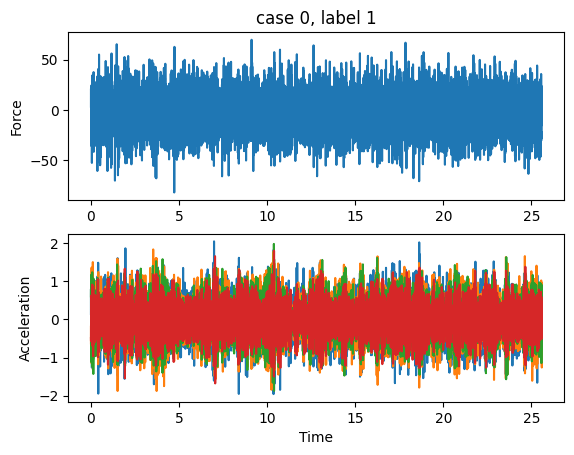

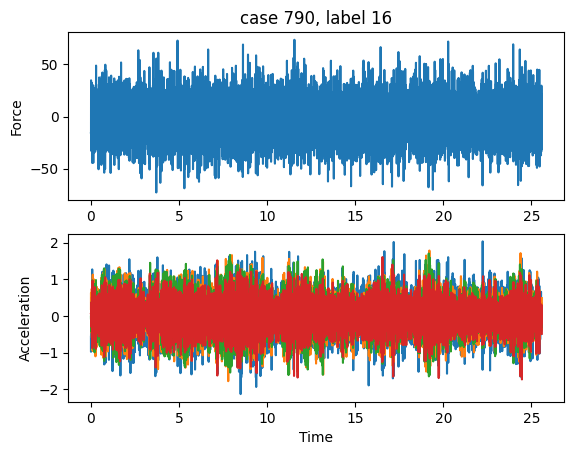

In [23]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [24]:
print(Ch2.shape)

(8192, 850)


# **Aula 02 - feature extraction and linear models**


4. Obtain Features

*4.a.a*
Obtendo a matriz X1

In [25]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

na = 30
res1_list = []
res2_list = []
res3_list = []
res4_list = []

for i in range(Nc):
    res1 = AutoReg(Ch2[:,i], lags=na, trend='n').fit()
    res2 = AutoReg(Ch3[:,i], lags=na, trend='n').fit()
    res3 = AutoReg(Ch4[:,i], lags=na, trend='n').fit()
    res4 = AutoReg(Ch5[:,i], lags=na, trend='n').fit()

    res1_list.append(res1.params)
    res2_list.append(res2.params)
    res3_list.append(res3.params)
    res4_list.append(res4.params)

# Os parâmetros 'res' são de Ordem 30 com 120 linhas
res1 = np.array(res1_list)
res2 = np.array(res2_list)
res3 = np.array(res3_list)
res4 = np.array(res4_list)

X1 = np.concatenate([res1, res2, res3, res4], axis=1)
X1.shape

(850, 120)

*4.a.b*
Obtendo a matriz X2

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # 95% da variância (solicitado pelo prof)
X2 = pca.fit_transform(X1)

X2.shape

(850, 5)

*4.b*
Scale de todas as dimensões para -1 e 1



In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X2_scaled = scaler.fit_transform(X2)

*4.c*
Visualizar e comparar X1 e X2 - mostrar procedimento de extração de características.

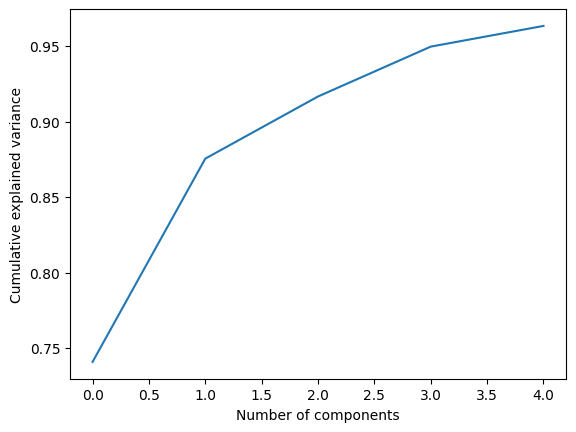

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

5. Softmax Model com *X2* (inputs) e *y* (outputs)

In [29]:
from sklearn.linear_model import LogisticRegression

model = logistic = LogisticRegression(max_iter=500) #hiper parâmetros aleatórios, somente para entendermos agora
model.fit(X2_scaled, y_target)

yhat = model.predict(X2_scaled)

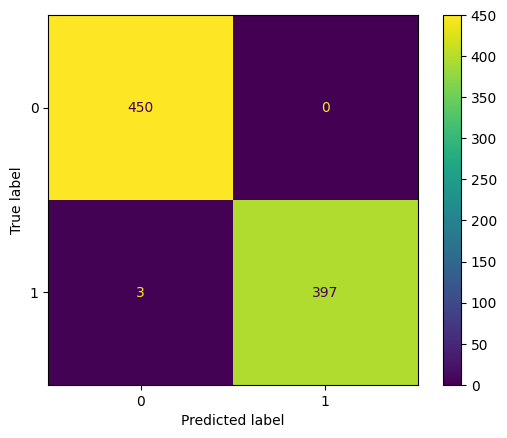

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_target, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# **Aula 03 - SVM e KNN models**


*Sugestão para variar mais a abordagem:* Separação de dados em **train** e **teste**

In [31]:
from sklearn.model_selection import train_test_split

# 30% dados para teste
# X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_target, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X1, y_target, test_size=0.30, random_state=42)


In [32]:
X_train.shape

(595, 120)

1. Teste dos modelos SVM e kNN

*1.1* SVM example

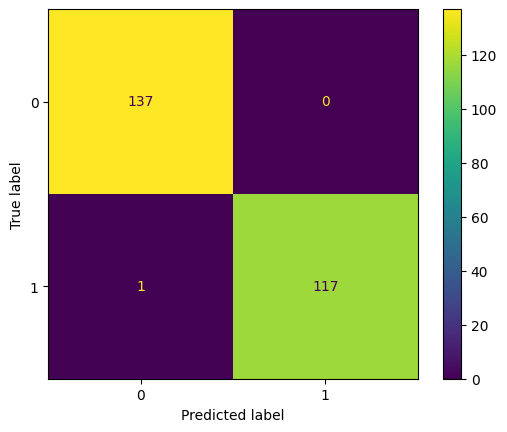

In [33]:
from sklearn.svm import SVC

# model_svc = SVC()

model_svc = SVC(kernel='rbf', C=0.1, gamma="auto") #hiper parâmetros aleatórios, somente para entender funcionamento

# model_svc.fit(X2_scaled, y_target)
# yhat_svc = model_svc.predict(X2_scaled)
model_svc.fit(X_train, y_train)         # Treinando
yhat_svc = model_svc.predict(X_test)    # Testando


cm_svc = confusion_matrix(y_test, yhat_svc)

disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc).plot()
plt.show()

*1.2* KNN example

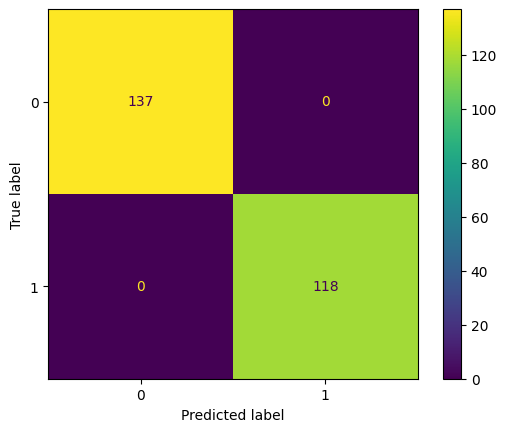

In [34]:
from sklearn.neighbors import KNeighborsClassifier

model.knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean')   # Exemplo aula

model.knn.fit(X_train, y_train)

yhat_knn = model.knn.predict(X_test)

cm = confusion_matrix(y_test, yhat_knn)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

#### Testes aleatórios com os hiperarâmetros para a obtenção de resultados melhores para cada modelo.
Gerado um código para testes com as referências do `RandomizedSearchCV`

[Ref. 01](https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning)

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

param_grids = []

# Define the parameter grids for SVC and KNN
param_grids.append( #SVC
    {
        "C":       stats.loguniform(1e-1, 1e3),
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree":  stats.randint(2, 5),
        "gamma":   stats.loguniform(1e-4, 1e0),
    }
)

param_grids.append( #KNN
    {
        "n_neighbors": stats.randint(2, 100),
        "weights": ["uniform", "distance"],
    }
)

model_svc = SVC()
model_knn = KNeighborsClassifier()

random_search_svc = RandomizedSearchCV(estimator=model_svc, param_distributions=param_grids[0], n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
random_search_knn = RandomizedSearchCV(estimator=model_knn, param_distributions=param_grids[1], n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)

random_search_svc.fit(X_train, y_train)
random_search_knn.fit(X_train, y_train)

print("Best parameters for SVC (Randomized Search):", random_search_svc.best_params_)
print("Best score for SVC (Randomized Search):", random_search_svc.best_score_)
print("Best parameters for KNN (Randomized Search):", random_search_knn.best_params_)
print("Best score for KNN (Randomized Search):", random_search_knn.best_score_)

Best parameters for SVC (Randomized Search): {'C': 254.73199893997503, 'degree': 4, 'gamma': 0.24718735897147096, 'kernel': 'rbf'}
Best score for SVC (Randomized Search): 1.0
Best parameters for KNN (Randomized Search): {'n_neighbors': 44, 'weights': 'distance'}
Best score for KNN (Randomized Search): 0.9966386554621849


Testando a comparação de modelos

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
# parâmetros obtidos no código anterior
best_params_svc = {'C': 497.0144223350601, 'degree': 3, 'gamma': 0.6682625754343029, 'kernel': 'linear'}
best_params_knn = {'n_neighbors': 55, 'weights': 'distance'}

# Inicializando modelos com os parâmetros
model_svc = SVC(**best_params_svc)
model_knn = KNeighborsClassifier(**best_params_knn)


model_svc.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

y_pred_svc = model_svc.predict(X_test)
y_pred_knn = model_knn.predict(X_test)


# Métricas SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

# Métricas KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')


# Results
print(f"Results for SVC:")
print(f" - Acc: {accuracy_svc:.4f}")
print(f" - Precision: {precision_svc:.4f}")
print(f" - Recall: {recall_svc:.4f}")
print(f" - F1 Score: {f1_svc:.4f}")
print()

print(f"Results for KNN:")
print(f" - Acc: {accuracy_knn:.4f}")
print(f" - Precision: {precision_knn:.4f}")
print(f" - Recall: {recall_knn:.4f}")
print(f" - F1 Score: {f1_knn:.4f}")


Results for SVC:
 - Acc: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1 Score: 1.0000

Results for KNN:
 - Acc: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1 Score: 1.0000


# **AULA 04 - Aprendizado Supervisionado II**


So far we have used softmax, SVC, and kNN models. Now we will create them
again with the same 3-storey structure dataset but using hyperparameter
tuning by randomized search. To that end, provide the following items:

In [38]:
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.metrics import accuracy_score

1. Split your dataset into a) training/validation and b) test datasets (e.g.60/40% ratio split)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X1, y_target, test_size=0.4, random_state=42)

In [40]:
# Definição dos modelos
models = []

models.append(("LRG", LogisticRegression))
models.append(("SVC", SVC))
models.append(("KNN", KNeighborsClassifier))

param_grids = []

param_grids.append(  # LogisticRegression
    {
        "LRG__C": stats.loguniform(1e-4, 1e0),
        "LRG__fit_intercept": [True, False],
        "LRG__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }
)

param_grids.append(  # SVC
    {
        "SVC__C": stats.loguniform(1e-1, 1e3),
        "SVC__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "SVC__degree": stats.randint(2, 5),
        "SVC__gamma": stats.loguniform(1e-4, 1e0),
    }
)

param_grids.append(  # KNN
    {
        "KNN__n_neighbors": stats.randint(2, 100),
        "KNN__weights": ["uniform", "distance"],
    }
)

2. Use randomized search with repeated cross-validation for hyperparameter
tuning. Use e.g.

a. Definição de `n_splits = 5` e `n_repeats = 50` para a `K-fold Cross-Validation`

b. Definição de um `n_iter = 100`, `n_jobs = -1` `cv = rkf ` (Gerado na instrução RepeatedKFold) e `scoring = accuracy` (método escolhido foi a acurácia)

In [41]:
# 2.a - Definição dos parâmetros para o k-fold cross-validation
n_splits = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# 2.a - Definição dos outros parâmetros necessários
n_iter = 100
n_jobs = -1
scoring = "accuracy"

best_estimators = []
for k, (model_name, model) in enumerate(models):

    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])

    param_grid = param_grids[k]

    # RandomizedSearch com cross-validation
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=n_iter,
        scoring=scoring, n_jobs=n_jobs, cv=rkf, random_state=42, verbose=1
    )

    random_search.fit(X_train, y_train)

    best_estimators.append((model_name, random_search.best_estimator_))

    print(f"Melhores parâmetros para {model_name}: {random_search.best_params_}")

Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para LRG: {'LRG__C': 0.7706343825607372, 'LRG__fit_intercept': True, 'LRG__solver': 'newton-cg'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para SVC: {'SVC__C': 24.81040974867808, 'SVC__degree': 4, 'SVC__gamma': 0.006071989493441302, 'SVC__kernel': 'poly'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para KNN: {'KNN__n_neighbors': 16, 'KNN__weights': 'uniform'}


3. Try to compare with the results obtained with the default configurations of
each model constructor

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Comparação com modelos default - sem hiperparâmetros
default_estimators = []
for model_name, model in models:
    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])
    clf.fit(X_train, y_train)
    default_estimators.append((model_name, clf))


print("\nResultados para configurações default:")
for model_name, clf in default_estimators:
    y_pred = clf.predict(X_test)
    print(f"{model_name} - Acc: {accuracy_score(y_test, y_pred)}")

print("\nResultados para modelos com hiperparâmetros otimizados:")
for model_name, clf in best_estimators:
    y_pred = clf.predict(X_test)
    print(f"{model_name} - Acc: {accuracy_score(y_test, y_pred)}")


Resultados para configurações default:
LRG - Acc: 1.0
SVC - Acc: 1.0
KNN - Acc: 1.0

Resultados para modelos com hiperparâmetros otimizados:
LRG - Acc: 1.0
SVC - Acc: 1.0
KNN - Acc: 1.0


# **AULA 05 - Aprendizado Supervisionado III**

Adição dos modelos de `DecisionTree` e `RandomForest` às definições já feitas anteriormente

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [44]:
models.append(("DTC", DecisionTreeClassifier))
models.append(("RFC", RandomForestClassifier))

param_grids.append(  # DTC
    {
        "DTC__criterion": ["entropy", "gini"],
        "DTC__splitter": ["best", "random"],
        "DTC__max_depth": stats.randint(2, 20),
        "DTC__max_features": stats.uniform(),
    }
)

param_grids.append(  # RFC
    {
        "RFC__n_estimators": stats.randint(2, 100),
        "RFC__criterion": ["log_loss", "gini", "entropy"],
        "RFC__max_depth": stats.randint(2, 20),
        "RFC__max_features": stats.uniform(),
    }
)

*Script de Cross-validation e RandomizedSearch repetido para a obtenção dos melhores hiperparâmetros*

In [45]:
n_splits = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

n_iter = 10
n_jobs = -1
scoring = "accuracy"

best_estimators = []
for k, (model_name, model) in enumerate(models):
    # Create an instance of the model here
    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])  # Create an instance of the model class

    param_grid = param_grids[k]

    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=n_iter,
        scoring=scoring, n_jobs=n_jobs, cv=rkf, random_state=42, verbose=1
    )

    random_search.fit(X_train, y_train)

    best_estimators.append((model_name, random_search.best_estimator_))

    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Fitting 250 folds for each of 10 candidates, totalling 2500 fits
Best parameters for LRG: {'LRG__C': 0.13145103232150104, 'LRG__fit_intercept': True, 'LRG__solver': 'lbfgs'}
Fitting 250 folds for each of 10 candidates, totalling 2500 fits
Best parameters for SVC: {'SVC__C': 24.81040974867808, 'SVC__degree': 4, 'SVC__gamma': 0.006071989493441302, 'SVC__kernel': 'poly'}
Fitting 250 folds for each of 10 candidates, totalling 2500 fits
Best parameters for KNN: {'KNN__n_neighbors': 16, 'KNN__weights': 'uniform'}
Fitting 250 folds for each of 10 candidates, totalling 2500 fits
Best parameters for DTC: {'DTC__criterion': 'entropy', 'DTC__max_depth': 12, 'DTC__max_features': 0.8661761457749352, 'DTC__splitter': 'random'}
Fitting 250 folds for each of 10 candidates, totalling 2500 fits
Best parameters for RFC: {'RFC__criterion': 'log_loss', 'RFC__max_depth': 11, 'RFC__max_features': 0.04666566321361543, 'RFC__n_estimators': 61}


# **AULA 06 - Aprendizado Não-Supervisionado**


1. Apply the k-means algorithm with the reduced dimensions;

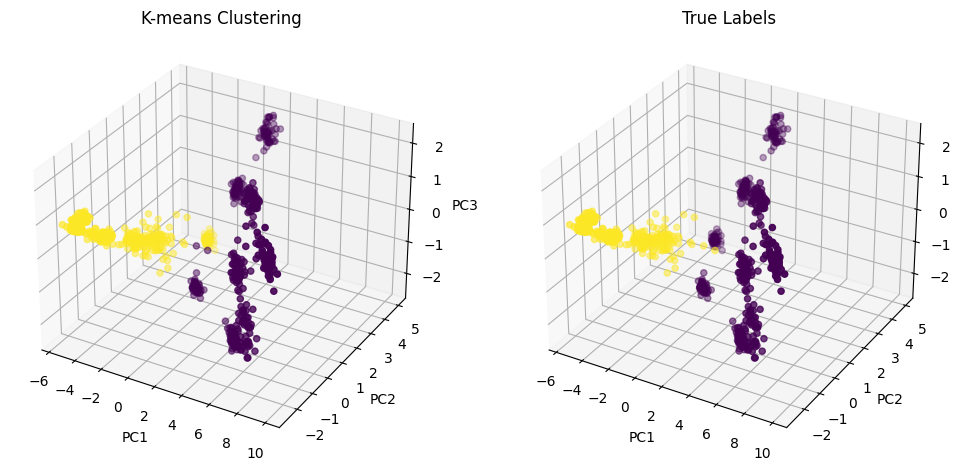

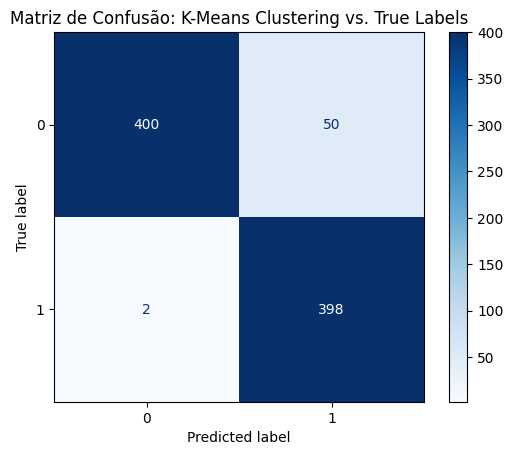

In [46]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Usar as 3 principais dimensões (pós PCA)
X_kmeans = X2[:, :3]

# Aplicar o K-means
kmeans = KMeans(n_clusters=2, random_state=42)  # Teste com 2 clusters (com ou sem danos)
kmeans.fit(X_kmeans)
labels_kmeans = kmeans.labels_

# Visualização 3D dos clusters gerados pelo K-means
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_kmeans[:, 0], X_kmeans[:, 1], X_kmeans[:, 2], c=labels_kmeans)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K-means Clustering')

# Visualização 3D dos rótulos corretos
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_kmeans[:, 0], X_kmeans[:, 1], X_kmeans[:, 2], c=y_target)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('True Labels')

plt.show()


# matriz de Confusão
cm = confusion_matrix(y_target, labels_kmeans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão: K-Means Clustering vs. True Labels")
plt.show()


2. Visualização do dataset usando **t-SNE**

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

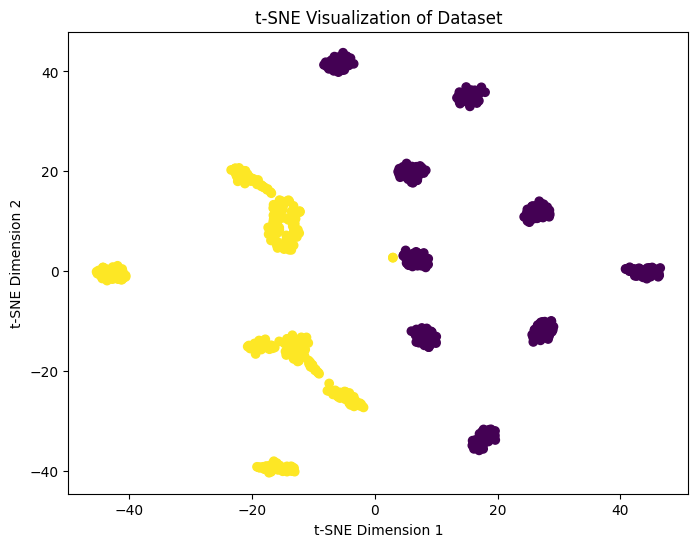

In [48]:
tsne = TSNE(n_components=2, random_state=42)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)

X_tsne = tsne.fit_transform(X1)  # Usei X1 - sem o PCA

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_target)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Dataset')
plt.show()

3. Construir uma SVM de classificação de uma classe para modos nominais e de falha


In [49]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Selecionar os dados nominais (sem falha) onde y_target é False
X_nominal = X1[~y_target]

# Treinamento da One-Class SVM usando apenas os dados nominais
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
ocsvm.fit(X_nominal)


y_pred_ocsvm = ocsvm.predict(X1)

# Convertendo a saída de -1 (falha) e 1 (nominal) para 0 (falha) e 1 (nominal) para facilitar a comparação
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, False, True)


print("Matriz de Confusão:")
print(confusion_matrix(y_target, y_pred_ocsvm))

print("\nRelatório de Classificação:")
print(classification_report(y_target, y_pred_ocsvm, target_names=['Nominal (False)', 'Falha (True)']))


Matriz de Confusão:
[[406  44]
 [  8 392]]

Relatório de Classificação:
                 precision    recall  f1-score   support

Nominal (False)       0.98      0.90      0.94       450
   Falha (True)       0.90      0.98      0.94       400

       accuracy                           0.94       850
      macro avg       0.94      0.94      0.94       850
   weighted avg       0.94      0.94      0.94       850



# **AULA 07 e 08 - Artificial Neural Networks (ANN)**
Criação e treinamento de um modelo simples e comparações com os outros já treinados.


In [81]:
!nvidia-smi   #Somente para verificar se a GPU do ambiente está ativada

Fri Sep 27 09:30:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              28W /  70W |    261MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

1. Build an artificial neural network for multiclass classification

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_target, test_size=0.2, random_state=42)

# Build the neural network model
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(len(np.unique(y_target)), activation='softmax'))

# Compile the model
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7612 - loss: 0.6101 - val_accuracy: 1.0000 - val_loss: 0.4002
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.3255 - val_accuracy: 1.0000 - val_loss: 0.1749
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.0648
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0468 - val_accuracy: 1.0000 - val_loss: 0.0291
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0055
Ep

*Orgainzação das variáveis para dar mais clareza*

In [74]:
X_train_svc, X_test_svc, y_train_svc, y_test_svc  = train_test_split(X1, y_target, test_size=0.30, random_state=42)
X_train_dt, X_test_dt, y_train_dt, y_test_dt      = train_test_split(X1, y_target, test_size=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_target, test_size=0.2, random_state=42)

*Script de test e comparação com os outros resultados ods modelos anteriores*

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Evaluate KNN
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Evaluate SVC
y_pred_svc = model_svc.predict(X_test_svc)
accuracy_svc = accuracy_score(y_test_svc, y_pred_svc)
precision_svc = precision_score(y_test_svc, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test_svc, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test_svc, y_pred_svc, average='weighted')

# Evaluate DecisionTree
y_pred_dtc = best_estimators[3][1].predict(X_test_dt)
accuracy_dtc = accuracy_score(y_test_dt, y_pred_dtc)
precision_dtc = precision_score(y_test_dt, y_pred_dtc, average='weighted')
recall_dtc = recall_score(y_test_dt, y_pred_dtc, average='weighted')
f1_dtc = f1_score(y_test_dt, y_pred_dtc, average='weighted')

# Evaluate RandomForest
y_pred_rfc = best_estimators[4][1].predict(X_test_dt)
accuracy_rfc = accuracy_score(y_test_dt, y_pred_rfc)
precision_rfc = precision_score(y_test_dt, y_pred_rfc, average='weighted')
recall_rfc = recall_score(y_test_dt, y_pred_rfc, average='weighted')
f1_rfc = f1_score(y_test_dt, y_pred_rfc, average='weighted')

# Evaluate Neural Network
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn, average='weighted')
recall_nn = recall_score(y_test, y_pred_nn, average='weighted')
f1_nn = f1_score(y_test, y_pred_nn, average='weighted')

# Print Results
print(f"KNN - Accuracy: {accuracy_knn:.4f}, Precision: {precision_knn:.4f}, Recall: {recall_knn:.4f}, F1: {f1_knn:.4f}")
print(f"SVM - Accuracy: {accuracy_svc:.4f}, Precision: {precision_svc:.4f}, Recall: {recall_svc:.4f}, F1: {f1_svc:.4f}")
print(f"DecisionTree - Accuracy: {accuracy_dtc:.4f}, Precision: {precision_dtc:.4f}, Recall: {recall_dtc:.4f}, F1: {f1_dtc:.4f}")
print(f"RandomForest - Accuracy: {accuracy_rfc:.4f}, Precision: {precision_rfc:.4f}, Recall: {recall_rfc:.4f}, F1: {f1_rfc:.4f}")
print(f"Neural Network - Accuracy: {accuracy_nn:.4f}, Precision: {precision_nn:.4f}, Recall: {recall_nn:.4f}, F1: {f1_nn:.4f}")



# ------------------------------------------------------------------------------
# Usando classification report para compilar a análise

print("\n\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))            # KNN
print("SVM Classification Report:\n", classification_report(y_test_svc, y_pred_svc))            # SVC
print("DecisionTree Classification Report:\n", classification_report(y_test_dt, y_pred_dtc))    # DT
print("RandomForest Classification Report:\n", classification_report(y_test_dt, y_pred_rfc))    # RF
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))      # ANN

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
KNN - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
SVM - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
DecisionTree - Accuracy: 0.9912, Precision: 0.9912, Recall: 0.9912, F1: 0.9912
RandomForest - Accuracy: 0.9971, Precision: 0.9971, Recall: 0.9971, F1: 0.9971
Neural Network - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


KNN Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00        89
        True       1.00      1.00      1.00        81

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

SVM Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       137
        True       1.00      1.00      1.00       118

    accuracy                      

### **Análise dos resultados obtidos**

Como vemos acima, alguns modelos apresentam precisão, recall e F1-score igual a 1 para ambas as classes, indicando que eles não cometeram erros na classificação. Porém tenho algumas dúvidas quanto a esta "perfeição", uma vez que pode ser casos de *Overfitting* ou pouca variação no dataset que usei.

Talvez seja necessário tratar os dados de maneira diferente e separá-los corretamente, isso deve trazer novos resultados.